# NTDS Project : BEER SUGGESTOR
Balsa Aurélie, Broisin Matthieu, Moscardini Alexandre and Willemin Jérémie, *Master students*, [EPFL](http://epfl.ch)

[Data link](https://drive.google.com/file/d/1bMbxgzVB7NpG3_XvFj-XmWq9hIP26FZt/view?usp=sharing)

## Content

1. [Introduction](#introduction)
1. [Data Collection, Cleaning and Storing](#datacleaning)
1. [Visualization of the Dataset](#visualization)
1. [Graph Construction](#graphConstruction)
1. [Clustering](#clustering)
1. [Conclusion](#conclusion)

<a id='introduction'></a>
## Introduction
The aim of this project is to create a Beer Suggestor to help discover/choose new beers when user preferences have been set. The idea behind this project is that a user could discover new beers based on a beer of reverance that the user particulary like. Our program, based on a similarity graph, should output five beers that are close, in term of the features we selected,  to the reference beer provided by the user.

The following steps have been made:
* Data collection/cleaning/saving
* Choice of the features 
* The creation and the visualisation of the dataset
* Graph construction and recommendation of beers
* Clustering on locations and features

In [1]:
%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML 

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import ast
from mpl_toolkits.basemap import Basemap
import warnings
import itertools
from pygsp import graphs, filters, plotting
import networkx as nx
from sklearn.cluster import KMeans, DBSCAN
from pyproj import Proj

plt.rcParams['figure.figsize'] = (15, 10)
warnings.filterwarnings('ignore')
plotting.BACKEND = 'matplotlib'

2018-01-22 17:51:27,216:[ERROR](pygsp.plotting.<module>): Cannot import packages for pyqtgraph: Traceback (most recent call last):
  File "/Users/aureliebalsa/anaconda3/lib/python3.5/site-packages/pygsp/plotting.py", line 43, in <module>
    import pyqtgraph as qtg
  File "/Users/aureliebalsa/anaconda3/lib/python3.5/site-packages/pyqtgraph/__init__.py", line 13, in <module>
    from .Qt import QtGui
  File "/Users/aureliebalsa/anaconda3/lib/python3.5/site-packages/pyqtgraph/Qt.py", line 133, in <module>
    from PyQt4 import QtGui, QtCore, uic
ImportError: cannot import name 'QtGui'



<a id='datacleaning'></a>
## 2. Data Collection, Cleaning and Storing
The data has been collected manually from [BreweryDB](http://www.brewerydb.com/) using an API in order to create the DataBase. BreweryDB is a collection of data surrounding the beer and the breweries. All the data are provided by users and then checked to ensure accuracy. For this reason the data collected might have different information for one beer to another. So, in order to clean the data, features have been chosen to be kept. The following features have been selected:
* Localisation of the brewery (Longitude, Latitude)
* SRM value: is an indication of the color of the beer, as seen on figure below.
* IBU value: is an indication of the bitterness of the beer.
* ABV value: is the amount of alcohol by volume, it's given as a percentage.

In [2]:
Image(url= "http://www.franklinbrew.org/wp/wp-content/uploads/2011/01/srm.jpg",width=300) 

The figure above shows the SRM values. These values goes from 0 to 40 corresponds to the color of the beer

These features have been chosen because they give a good idea of the different kind of beers. Moreover, people are usually familiar with these features and most of the beers have them.

Since some of features selected are not available for certain beer, the data need to be cleaned. The beers that don't contain information on any of these features are discarded and then saved in the file bdb_cleaned2.csv.

The following fonctions are used to collect, clean and save the dataset that will be later used.

** API ** 

We created an app on the website [BreweryDB](http://www.brewerydb.com/developers/apps) and generate an API key (actually, as the maximum requests number is limited to 400 per day, we created two apps to gather enough data. We can use one or the other by reading credentials.ini or credentials2.ini).

credentials.ini
<br>
```
[brewerydb]
api_key = secret
```

credentials2.ini
<br>
```
[brewerydb]
api_key = secret
```

In [3]:
# Read the confidential API key.
credentials2 = configparser.ConfigParser()
credentials2.read(os.path.join('credentials2.ini'))
api_key = credentials2.get('brewerydb', 'api_key')

We encounter one early problem when building the dataset. Indeed, since we didn't pay the website to have a premium access, we couldn't simply use an API request to download all the dataset. To overcome this problem, we used the following trick: The acquisition of beers is done by downloading all beers belonging to a specific glass ID, and doing that for all glass ID and all pages. There are 50 results by page, and we can find on the website the number of pages per glass.

In [4]:
# Recovery of the beers by Glass ID
def get_by_glass(glass_id, page_number): # Glass Ids are from 1 to 14 without 11 and 12
    BASE_URL = 'http://api.brewerydb.com/v2/'
    url = '{}beers?glasswareId={}&p={}&withBreweries=Y&key={}'.format(BASE_URL, glass_id, page_number, api_key)
    response = requests.get(url).json()
    return response

We create a function to delete a specific field in the dataFrame we get from BreweryDB. We used a function in order to be able to check in the dataFrame if the field exists, because all the beers do not have always exactly the same fields.

In [5]:
# Delete the field that are not used in the DataBase
def del_field(df, field):
    if (field in df):
        del df[field]
    return df

In the same spirit that the function *del_field*, we have a function to delete an entry of a dictionnary stored in a field of the dataFrame.

In [6]:
# Delete a specific entry for a field in a specific datafield
def del_entry(df, field, entry):
    if (field in df):
        for i in range (0, len(df)):
            if (df[field].loc[i]==df[field].loc[i]):
                if (entry in df[field].loc[i]):
                    del df[field].loc[i][entry]
    return df

In the different beers loaded from BreweryDB, we gather a field named *breweries* which defines the location of the brewery where the beer was made. Since, the origin of the beer was considered as an interesting feature, some of the entries of this dictionnary, if they exist (locality, longitude, latitude and country), need to be kept. To be able to use it simply, we want to convert them into fields of the dataFrame. The fonction *clean_breweries* takes the dataFrame and creates the new 4 fields by retrieving the information in the field *breweries* and delete it after. During this process, we check that every field exists before accessing the information because we do not want the code to crash if there is a missing field.

In [7]:
# Keep only important information on the brewery location: locality (city), longitude, latitude and country
# The field locatity, longitude, latitude and country are added to the dataset as a separated column.
def clean_breweries(df):
    field = 'locations'
    f1 = 'locality'
    f2 = 'longitude'
    f3 = 'latitude'
    f4 = 'country'
    liste1 = []
    liste2 = []
    liste3 = []
    liste4 = []
    for i in range (0, len(df)):
        locality = '0'
        long = 0
        lat = 0
        country = '0'
        if (field in df['breweries'][i][0]):
            diction = df['breweries'][i][0][field]
            if (f1 in diction[0]):
                locality = diction[0][f1]
                liste1.append(locality)
            if (f2 in diction[0]):
                long = diction[0][f2]
                liste2.append(long)
            if (f3 in diction[0]):
                lat = diction[0][f3]
                liste3.append(lat)
            if (f4 in diction[0]):
                if ('name' in diction[0][f4]):
                    country = diction[0][f4]['name']
                    liste4.append(country)
    dtemp1 = pd.DataFrame({f1:liste1})
    dtemp2 = pd.DataFrame({f2:liste2})
    dtemp3 = pd.DataFrame({f3:liste3})
    dtemp4 = pd.DataFrame({f4:liste4})
    df = pd.concat([df, dtemp1, dtemp2, dtemp3, dtemp4], axis=1)
    return df

The two following functions *correct_strings_df* and *correct_strings_df_dict* permit to clean the strings in the dataFrame. Indeed, to be able to store our dataFrame in a csv file and then load it, we need to remove all the special characters in the strings. It exists several ways to do it with the different Python libraries, but they also remove the spaces, and some other characters that need to be kept. This is the reason why our own functions were coded to clean the strings.

In [8]:
# Replace all characteres in strings that can be problematics where the feature is only a string 
str_prohibed = "™&~#'{([|\/^@=+°$£¤*µ%¨!§,?;.:<>*²])}ø£Ø×ƒªº¿®¬½¼¡«»|`’·—_“”‘’‘–  "
def correct_strings_df(df, column_name):
    if (column_name in df) : 
        test = df[column_name]
        for i in range (0, len(df)):
            string = test.get_value(i, column_name)
            if (string == string):
                for char in string:
                    if char in str_prohibed:
                        string = string.replace(char,' ')
                    if char in "ß":
                        string = string.replace(char,'S')
                    if char in "äâàåãÄÅÆæáÁÀÃÂ":
                        string = string.replace(char,'a')
                    if char in "éèëêÉ":
                        string = string.replace(char,'e')
                    if char in "üûùÜúÙÚÛ":
                        string = string.replace(char,'u')
                    if char in "ôöòÖóÒÓÔÕ":
                        string = string.replace(char,'o')
                    if char in "ñÑ":
                        string = string.replace(char,'n') 
                    if char in "çÇ":
                        string = string.replace(char,'c')
                    if char in "ïîìíÍÌÎÏ":
                        string = string.replace(char, 'i')
                    if char in "ÿýŸÝ":
                        string = string.replace(char, 'y')
                df[column_name].loc[i] = string
    return df

In [9]:
# Replace all characteres in strings that can be problematics where the feature is a dictonnary with different strings
def correct_strings_df_dict(df, column_name, entry_name):
    if (column_name in df):
        collection_dic = df[column_name]
        #print(collection_dic)#[i][column_name]
        for i in range (0, len(collection_dic)):
            if (collection_dic[i]==collection_dic[i]):
                string = collection_dic[i][entry_name]
                for char in string:
                    if char in str_prohibed:
                        string = string.replace(char,' ')
                    if char in "ß":
                        string = string.replace(char,'S')
                    if char in "äâàåãÄÅÆæáÁÀÃÂ":
                        string = string.replace(char,'a')
                    if char in "éèëêÉ":
                        string = string.replace(char,'e')
                    if char in "üûùÜúÙÚÛ":
                        string = string.replace(char,'u')
                    if char in "ôöòÖóÒÓÔÕ":
                        string = string.replace(char,'o')
                    if char in "ñÑ":
                        string = string.replace(char,'n') 
                    if char in "çÇ":
                        string = string.replace(char,'c')
                    if char in "ïîìíÍÌÎÏ":
                        string = string.replace(char, 'i')
                    if char in "ÿýŸÝ":
                        string = string.replace(char, 'y')
                df[column_name][i][entry_name] = string
    return df

Now that the functions to clean the gathered data are prepared, we can actually collect the beers. The list *glass_ids* defines the different kind of glasses, and *pages_per_glass* gives the number of pages for each glass_id. In every page obtained, we remove all the fields that are not needed (if they exist). The strings we want to keep are corrected and we handle *breweries*. Then the data is stored in csv files. The read of the data is simply a sanity check to verify that it can be loaded after saving it.

To use this code, one should be aware that the page 176 for the glass_id 5 contains special characters that we cannot remove, and so it is not part of the dataset and should lead to an error when loaded.

In [10]:
# Recovery and cleaning of the features that are not used
glass_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14]
pages_per_glass = [3, 7, 7, 17, 234, 21, 2, 26, 13, 2, 3, 1]

for g in range (10, len(glass_ids)): 
    glass_number = glass_ids[g]
    for p in range (0, pages_per_glass[g]):
        page_number = p+1
        
        #COLLECTING
        res = get_by_glass(glass_number, page_number)
        d2 = pd.DataFrame(res['data'])
        
        # CLEANING
        d2 = del_field(d2, 'createDate')
        d2 = del_field(d2, 'foodPairings')
        d2 = del_field(d2, 'status')
        d2 = del_field(d2, 'statusDisplay')
        d2 = del_field(d2, 'updateDate')
        d2 = del_field(d2, 'labels')
        d2 = del_field(d2, 'styleId')
        d2 = del_field(d2, 'description')
        d2 = del_field(d2, 'nameDisplay')
        d2 = del_field(d2, 'beerVariation')
        field = 'style'
        d2 = del_entry(d2, field, 'category')
        d2 = del_entry(d2, field, 'shortName')
        d2 = del_entry(d2, field, 'description')
        field = 'breweries'
        d2 = clean_breweries(d2)
        # Replace the special characters to avoid issues with .csv files
        d2 = correct_strings_df(d2, 'name')
        d2 = correct_strings_df_dict(d2,'style','name')
        d2 = correct_strings_df(d2, 'servingTemperature')
        d2 = correct_strings_df_dict(d2, 'available', 'description')
        
        d2 = correct_strings_df(d2, 'locality')
        d2 = correct_strings_df(d2, 'country')
        del d2['breweries']
        
        # STORAGE 
        str_dataName = './data/bdb_glass'+str(glass_number)+'_page'+str(page_number)+'.csv'
        d2.to_csv(str_dataName)
        # test
        beers1 = pd.read_csv(str_dataName, index_col=0)
        print('You got {} beer IDs for glass number = {} and page = {}.'.format(len(beers1), glass_number, page_number))


You got 50 beer IDs for glass number = 13 and page = 1.
You got 50 beer IDs for glass number = 13 and page = 2.
You got 33 beer IDs for glass number = 13 and page = 3.
You got 18 beer IDs for glass number = 14 and page = 1.


From the csv files, the data are retrieved and put in one single dataFrame called *beers*. This dataFrame is also saved in a csv file.

In [11]:
# Read all files saved (each page of each glass is saved in a different file) to save in one file only.
glass_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14]
pages_per_glass = [3, 7, 7, 17, 234, 21, 2, 26, 13, 2, 3, 1]

str_dataName = './data/bdb_glass14_page1.csv'
beers = pd.read_csv(str_dataName, index_col=0)

for g in range (0, len(glass_ids)-1):
    glass_number = glass_ids[g]
    for p in range (0, pages_per_glass[g]):
        page_number = p+1
        
        if (not(page_number == 176)):
            str_dataName = './data/bdb_glass'+str(glass_number)+'_page'+str(page_number)+'.csv'
            beers1 = pd.read_csv(str_dataName, index_col=0)
            #print(beers1)
            beers = beers.append(beers1, ignore_index=True)
beers
str_dataName = './data/bdb_all.csv'
beers.to_csv(str_dataName)
beers2 = pd.read_csv(str_dataName, index_col=0)


When loading the data, the cells of the dataFrame which contain dictionnaries are currently filled with strings. Hence, we need to convert these strings into dictionnaries using the function *stringToDict*. The function also informs if a cell contains a NaN.

In [12]:
# Function to change the string in a dictonnary
def stringToDict(df,field):
    indexNaN = []
    if field in df:
        for i in range (0,len(df)):
            diction = df[field][i]
            if (diction == diction):
                newdiction = ast.literal_eval(diction)
                df.set_value(i, field, newdiction)
            else:
                indexNaN.append(i)
    return df,indexNaN

In [13]:
str_dataName = './data/bdb_all.csv'
beers = pd.read_csv(str_dataName, index_col=0)
beers, indexnan_ava = stringToDict(beers,'available')
beers, indexnan_bre = stringToDict(beers,'breweries')
beers, indexnan_gla = stringToDict(beers,'glass')
beers, indexnan_srm = stringToDict(beers,'srm')
beers, indexnan_sty = stringToDict(beers,'style')
print("NaN for {} availables, {} breweries, {} glasses, {} srm and {} styles".format(len(indexnan_ava), len(indexnan_bre), len(indexnan_gla), len(indexnan_srm), len(indexnan_sty)))

NaN for 3818 availables, 0 breweries, 0 glasses, 12942 srm and 162 styles


Now that we have the full desired data, the missing fields for some beers need to be handle. After analyzing the database, there are 5 fields that we absolutely want : 
* abv 
* ibu 
* srm 
* longitude 
* latitude

For the three first features, we can replace the NaN by the mean value of the style of the beer. Indeed, for some beers, there exists a field named *style*, which gives the max and min value of abv, ibu and srm for the style of the beer. If there is no way to change the NaN, we simply discard the beer from the dataFrame.

In [14]:
# Function that look at all the features that are NaN and check if other informations are available such as "abvMin" 
# and "abvMax", these values are used to perform an average and replace the NaN value. This is done for abv, ibu and srm.
def cancel_NAN(df):
    
    for i in tqdm(range(0, len(df))):
        
        
        #--------abv
        if (not(df['abv'][i] == df['abv'][i])):
            if(df['style'][i] == df['style'][i]):
                if('abvMin' in df['style'][i] and 'abvMax' in df['style'][i]):
                    if(df['style'][i]['abvMin'] == df['style'][i]['abvMin'] and df['style'][i]['abvMax'] == df['style'][i]['abvMax']):
                        df['abv'][i] = (float(df['style'][i]['abvMin']) + float(df['style'][i]['abvMin']))/2.0
                
        #--------ibu      
        if (not(df['ibu'][i] == df['ibu'][i])):
            if(df['style'][i] == df['style'][i]):
                if('ibuMin' in df['style'][i] and 'ibuMax' in df['style'][i]):
                    if(df['style'][i]['ibuMin'] == df['style'][i]['ibuMin'] and df['style'][i]['ibuMax'] == df['style'][i]['ibuMax']):
                        df['ibu'][i] = (float(df['style'][i]['ibuMin']) + float(df['style'][i]['ibuMin']))/2.0
                
        #--------srm
        if (not(df['srmId'][i] == df['srmId'][i])):
            if(df['style'][i] == df['style'][i]):
                if('srmMin' in df['style'][i] and 'srmMax' in df['style'][i]):
                    if(df['style'][i]['srmMin'] == df['style'][i]['srmMin'] and df['style'][i]['srmMax'] == df['style'][i]['srmMax']):
                        df['srmId'][i] = (float(df['style'][i]['srmMin']) + float(df['style'][i]['srmMin']))/2.0

    return df

In [15]:
beers = cancel_NAN(beers)

100%|██████████| 16487/16487 [20:45<00:00, 13.24it/s]


In [16]:
# Detect if NaN remaining in the selected feature and change NaN value by -99 
for beer in tqdm(range(beers.shape[0])):
    val_abv = beers.loc[beer]['abv']
    val_ibu = beers.loc[beer]['ibu']
    val_srm = beers.loc[beer]['srmId']
    val_lon = beers.loc[beer]['longitude']
    val_lat = beers.loc[beer]['latitude']
    
    if not (val_abv == val_abv):
        beers.set_value(beer,'abv', -99)
    if not (val_ibu == val_ibu):
        beers.set_value(beer,'ibu', -99)
    if not (val_srm == val_srm):
        beers.set_value(beer,'srmId', -99)
    if not (val_lon == val_lon):
        beers.set_value(beer,'longitude', -99)
    if not (val_lat == val_lat):
        beers.set_value(beer,'latitude', -99)
    

100%|██████████| 16487/16487 [00:16<00:00, 1012.51it/s]


In [17]:
# Removing NaN (changed in -99) of Dataset
nan_tot = 0
for beer in tqdm(range(len(beers)-1,-1,-1)):
    val_abv = beers.loc[beers.index[beer]]['abv']
    val_ibu = beers.loc[beers.index[beer]]['ibu']
    val_srm = beers.loc[beers.index[beer]]['srmId']
    val_lon = beers.loc[beers.index[beer]]['longitude']
    val_lat = beers.loc[beers.index[beer]]['latitude']

    if( (val_abv == -99) or (val_ibu == -99) or (val_srm == -99) or (val_lon == -99) or (val_lat == -99)):
        beers = beers.drop([beers.index[beer]])
        

100%|██████████| 16487/16487 [00:24<00:00, 665.75it/s]


In [18]:
# Checking if there are some remaining NAN

list_abv = np.array([])
list_srm = np.array([])
list_ibu = np.array([])
list_lon = np.array([])
list_lat = np.array([])

for beer in tqdm(range(beers.shape[0])):
    val_abv = beers.loc[beers.index[beer]]['abv']
    if not (val_abv == val_abv):
        list_abv =np.append(list_abv, val_abv)
        
    val_srm = beers.loc[beers.index[beer]]['srmId']
    if not (val_srm == val_srm):
        list_srm = np.append(list_srm, val_srm)
        
    val_ibu = beers.loc[beers.index[beer]]['ibu']
    if not (val_ibu == val_ibu):
        list_ibu = np.append(list_ibu, val_ibu)
    
    val_lon = beers.loc[beers.index[beer]]['longitude']
    if not (val_lon == val_lon):
        list_lon = np.append(list_lon, val_lon)
    
    val_lat = beers.loc[beers.index[beer]]['latitude']
    if not (val_lat == val_lat):
        list_lat = np.append(list_lat, val_lat)

100%|██████████| 15369/15369 [00:15<00:00, 982.73it/s]


In [19]:
print("NaN for {} abv, {} srmId, {} ibu, {} longitude and {} latitude".format(len(list_abv), len(list_srm), len(list_ibu), len(list_lon), len(list_lat)))

NaN for 0 abv, 0 srmId, 0 ibu, 0 longitude and 0 latitude


After replacing the NaN and discard the beers where the NaN can not be replaced, the data is saved in one csv file.

In [20]:
# Save cleaned Dataset
str_dataName = './data/bdb_cleaned2.csv'
beers.to_csv(str_dataName)

In [21]:
# Recovery of the clean Dataset
beers = pd.read_csv('data/bdb_cleaned2.csv', index_col=0)

<a id='visualization'></a>
## Visualization of the Dataset
Once the entire cleaned dataset is built, it is interesting to see where the beers of the dataset come from. This is done in this section, where visualization of the dataset on a map is made.

In [22]:
# Saving all the latitudes and longitudes in matrices
nb_of_beer = beers.shape[0]
lats_beers = np.zeros(nb_of_beer)
lons_beers = np.zeros(nb_of_beer)
for beer in range(nb_of_beer):
    lats_beers[beer] = beers.loc[beers.index[beer]]['latitude']
    lons_beers[beer] = beers.loc[beers.index[beer]]['longitude']

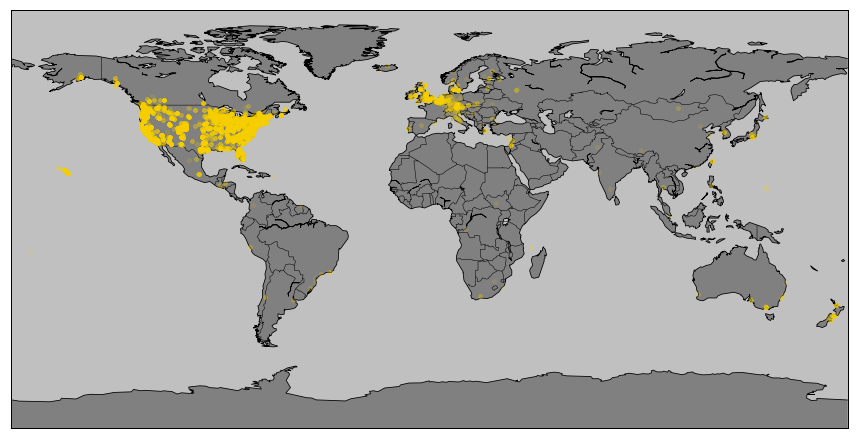

In [23]:
# Plot of the mondial map
mymap = Basemap(projection='cyl')

mymap.drawmapboundary(fill_color='silver')
mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


x_lons, y_lats = mymap(lons_beers, lats_beers)

mymap.scatter(x_lons, y_lats, marker='o',color='gold', s=15, zorder=5, alpha=0.1)


plt.show()

In the figure above is plotted the entire dataset (15'369 beers). Each dot represents a beer. Obviously, many beers comes from the same region, even the same brewery, resulting in superimposed representation.

What is important to notice is that the great majority of the beers are located in the USA. This could be explained by the fact that  [BreweryDB](http://www.brewerydb.com/) get their beers from a community that upload beer's data on their website and, because it is based in the USA, it may be more known in this part of the world.

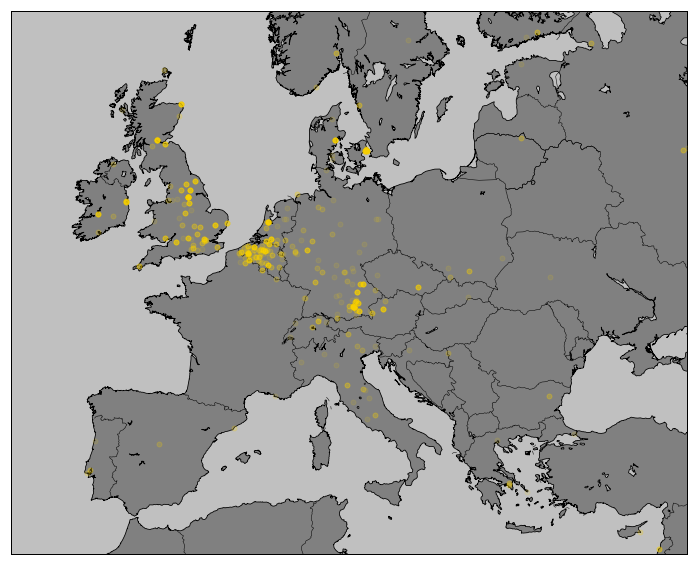

In [24]:
# Plot of Europe
ll_corner = [-15.292969, 33.550551] #long, lat
ur_corner = [37.749023, 61.371726] #long, lat 

mymap = Basemap(llcrnrlon=ll_corner[0],
              llcrnrlat=ll_corner[1],
              urcrnrlon=ur_corner[0],
              urcrnrlat=ur_corner[1],
              resolution = 'i',
              projection='merc',
              lon_0 = 0,
              lat_0 = 0)

mymap.drawmapboundary(fill_color='silver')
mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


x_lons, y_lats = mymap(lons_beers, lats_beers)

mymap.scatter(x_lons, y_lats, marker='o',color='gold', s=25, zorder=5, alpha=0.1)

plt.show()

The figure above presents the beer location in europe. Belgium is well known for being a huge producer of beer (and consumer too ;) ), and is well represented in the figure above. UK and Germany are present too. Then, it is mostly scattered individual beer.

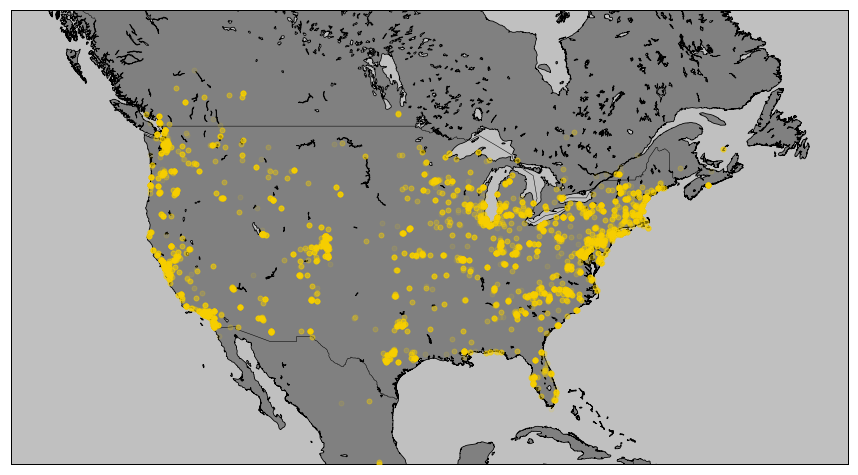

In [25]:
# Plot of America
ll_corner = [-139.174805, 19.344837] #long, lat
ur_corner = [-48.471680, 56.579154] #long, lat 

mymap = Basemap(llcrnrlon=ll_corner[0],
              llcrnrlat=ll_corner[1],
              urcrnrlon=ur_corner[0],
              urcrnrlat=ur_corner[1],
              resolution = 'i',
              projection='merc',
              lon_0 = 0,
              lat_0 = 0)

mymap.drawmapboundary(fill_color='silver')
mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


x_lons, y_lats = mymap(lons_beers, lats_beers)

mymap.scatter(x_lons, y_lats, marker='o',color='gold', s=25, zorder=5, alpha=0.1)

plt.show()

As already mentionned previously, most of the beers are located in the USA.

<a id='graphConstruction'></a>
## Graph Construction
This section will cover the analysis of the data. The first thing made was the construction of a Feature matrix that characterize our data. We actually divided the features into two categories. The first one being the features related to the beer itself (srm, ibu, abv), and another one related to the brewery (location of the beer). The purpose of the project being suggestions of beers, it is judicious to compute distances matrices that reflect the difference in terms of features between every beers. From these distances matrices, one can then computed an equivalent weight matrix to construct our network by ussing an appropriate kernel. A high weight means a high similarity between the beers.  These computations and graph construction are presented in this section.

To begin with, next cell is defining some constants and coefficient, the position matrix (LongLat) and the Feature matrix.
- The Feature matrix contains the features we kept for each beer. Each feature can be weighted individually. This could be used to personalise the suggestion to a specific individual. For example, if one is more sensitive to bitterness (ibu), it is recommended to increase the weight of this specific feature

- The LongLat matrix contains the geographic position of the brewery where the beers were made (latitude and longitude coordinates). Again, this feature can be weighted by the distance_weight coefficient. Indeed, in the following, we considered that the location should impact less than the other features (abv, ibu, srmId). Thus we set this coefficient to 0.1. This choice make sense because one is probably more interested to find a similar beer in terms of color, bitterness, alcohol than a similarity in the location. 

In [26]:
# parameters
features = ['abv', 'ibu', 'srmId'] # features we kept

features_weights = [1, 1, 1] # weights assigned to each features
distance_weight = 0.1 # weight assigned to the position (latitude and longitude)
 
kernel_width_coef = 1 # a coef that multiply the kernel_width in the Gaussian kernel)

tot_beers = beers.shape[0]

# construct matrix that contain longitude and latitude of each beer
LongLat = np.zeros((tot_beers, 2))
lats_beers = np.array(beers['latitude'].values)
lons_beers = np.array(beers['longitude'].values)
for row in range(LongLat.shape[0]):
    LongLat[row,0] = lons_beers[row]
    LongLat[row,1] = lats_beers[row]

# construct the features matrix    
Feature = np.zeros((tot_beers, len(features))) # Feature matrix N x 5     
i=0
for el in features:
    Feature[:,i] = beers[el]
    i+=1

list_indices = beers.index.values # a list with the index of beers to retrieve them with theirs index values

Next function (mapColumn) is used to "normalise" the features (column of the Feature matrix). It converts all column's values into values between 0 and 1. This is done in order to have a same range of values between each feature. It is an important step to do to insure that each feature have, initially, the same weight for further analyses.

In [27]:
def mapColumn(M):
    "map all features (column) values to values between 0 and 1"    
    for col in range(M.shape[1]):
        min_val = min(M[:,col])
        max_val = max(M[:,col])
        
        if(min_val==max_val):
            raise ValueError('Value cannot be mapped. min=max')
                
        mapped = np.array(list(map(lambda x: (x-min_val)/(max_val-min_val), M[:,col]))) 
        M[:,col] = mapped
            
    return M

In [28]:
Feature = mapColumn(Feature)

print(Feature.shape)

(15369, 3)


In [29]:
# multiply features individually by a factor, if, for example, we want that 'abv' impact more than another feature.
Feature = Feature @ np.diag(features_weights)

print(Feature.shape)

(15369, 3)


To compute the distance for the localisation (latitude and longitude) one can not simply use an euclidean-like distance metric but has to use a convenient one because the earth is spherical:

Longitude and latitude are included in the following intervals:
* longitude [-180°;180°]
* latitude [-90°,90°]

However, for example, beers that are located close to -180° or 180° in longitude, need to be considered as close since the earth is spherical. Thus the distance matrix must be computed with a specific metric that is [haversine function](https://en.wikipedia.org/wiki/Haversine_formula). The distance matrix for the other features are calculated using an euclidian formula. A detailed explanation of the calcul of distances is done [here](#distanceCalculation).

The following function is used to compute the real distance between two points on earth, given their latitudes and longitudes. This function comes from [stackoverflow](https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas)

In [30]:
# Calcul of the distance using the harvesine function
# from: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

<a id='distanceCalculation'></a>
** Calculation of the distances **

In order to build a graph, we need a weight matrix which is computed thanks to a Gaussian kernel : 

$$W_{i,j} = exp\left(\frac{-d_{i,j}^2}{\sigma^2}\right)$$ 

To calculate the distance between the nodes, we need to take into account two different things. First, on the three first features (abv, ibu, srm), we can take a classical distance. We choose the euclidean distance:

$$ d\left(u,v\right) = \|u-v\|_2 = \left(u-v\right)^T\left(u-v\right)$$

However for the two last features that are the longitude and the latitude of the corresponding brewery, we cannot calculate the euclidean distance. Indeed, the longitude is defined between -180° and 180°, but this is a cyclic metric, and we should consider that a point which have a longitude of 180° is the same thing that a point with longitude equal to -180°. Moreover, let's consider two nodes with latitude 0 and two nodes with latitude 45. If the longitude difference of the two couples of nodes are the same, then the two nodes with latitude 45 are closer than the two nodes with latitude 0. That is why the distance with the latitude and longitude is not computed as an euclidean distance, and the haversine function is used instead. This function allows us to compute a distance on a sphere thanks to the angles and the radius. 

Once we computed the to distances, we need to determine $d_{i,j}$, the total distance between two nodes. Since we normalized our features abv, ibu and srm thanks to the mapColumn function, the euclidean distance we computed should be in the interval $ \left[0,\sqrt{3}\right] $. However, the haversine distance has an order of magnitude of terrestrial distances, so it can go from 0 to about 20'000 km. That is why we rescale these two distances by divide them by their respective maximum value, and we built $d_{i,j}$: $$d_{i,j} = \frac{d_{i,j}^{euclidean}}{max_{i,j}\left(d_{i,j}^{euclidean}\right)} + \frac{d_{i,j}^{haversine}}{max_{i,j}\left(d_{i,j}^{haversine}\right)}$$

Since we want to control the influence of each distance, we put a weight in the distance calculation, and the true expression is : $$d_{i,j} = \frac{d_{i,j}^{euclidean}}{max_{i,j}\left(d_{i,j}^{euclidean}\right)} + w\frac{d_{i,j}^{haversine}}{max_{i,j}\left(d_{i,j}^{haversine}\right)}$$

This way we can increase or decrease the relative influence of the haversine distance with respect to the euclidean distance : if $w > 1$ the influence of the haversine distance is lower than the euclidean distance. 

In [31]:
# Calcul of the different distances matrices
D_features = np.zeros((tot_beers, tot_beers), dtype=np.float64) 
D_distances = np.zeros((tot_beers, tot_beers), dtype=np.float64)

# iterate through the upper half of the matrix (lower half being the same)
for combi in tqdm(itertools.combinations(range(0,tot_beers),2)):
    
    # features
    diff = abs(Feature[combi[0],:]-Feature[combi[1],:]) # difference between 2 beers
        
    # user related factors
    d_i = np.sqrt(np.dot(diff, np.transpose(diff))) # scalar product   
    
    D_features[combi[0], combi[1]] = d_i
    
    #distances
    dist = haversine_np(LongLat[combi[0],0], LongLat[combi[0],1], LongLat[combi[1],0], LongLat[combi[1],1])

    # user related factors
    d_i = dist
    
    D_distances[combi[0], combi[1]] = d_i
    
print(D_features.shape)
print(D_distances.shape)

118095396it [1:05:14, 30167.06it/s]

(15369, 15369)
(15369, 15369)


In [32]:
# Build the distances matrix
distances_matrix = D_features/np.max(D_features)+D_distances/np.max(D_distances)*distance_weight
# Make D symmetric
bigger = distances_matrix.transpose() > distances_matrix
distances_matrix = distances_matrix - distances_matrix*bigger + distances_matrix.transpose()*bigger
# Gaussian kernel
kernel_width_distances = distances_matrix.mean()*kernel_width_coef
W = np.exp(-distances_matrix**2/kernel_width_distances**2) 
np.fill_diagonal(W,0)

print(W.shape)

(15369, 15369)


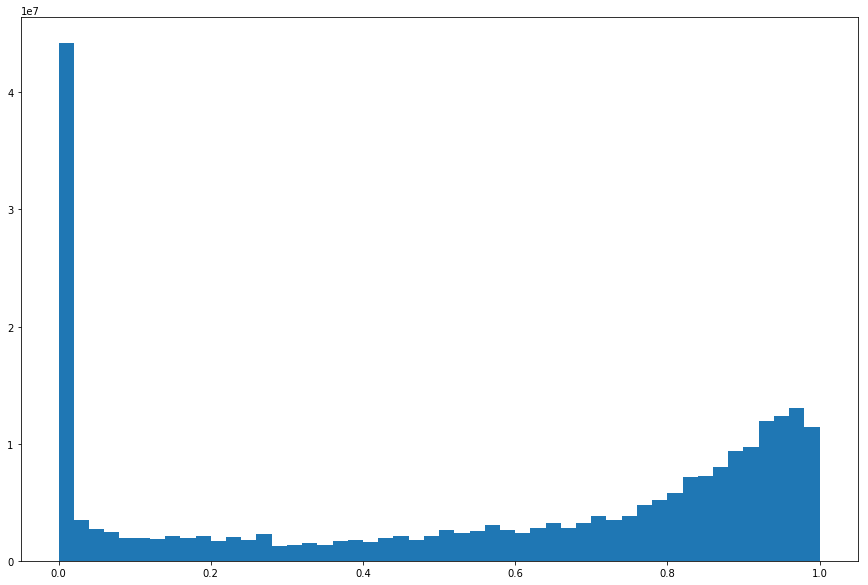

In [33]:
plt.hist(W[W > 0].reshape(-1), bins=50);

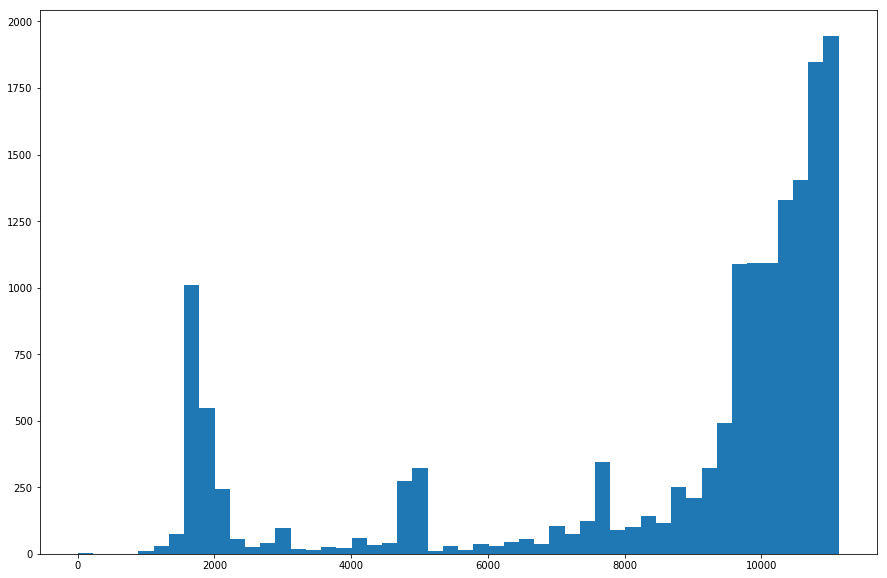

In [34]:
degrees = np.sum(W,0)
plt.hist(degrees, bins=50);

Since the matrix of weights is really heavy, we do not want to keep all the weights. To choose the weigths we discard, we sort the matrix and keep the strongest connexions for each node. 

In [35]:
NEIGHBORS = 1000
weights = np.copy(W)

for i in tqdm(range (0, int(weights.shape[0]))):
    sorted_indices = np.argsort(weights[i,0:(weights.shape[0])])

    for j in range (0, len(sorted_indices)-NEIGHBORS):
        weights[i,sorted_indices[j]]=0
        
# from assignment 1
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger
#plt.spy(weights)

100%|██████████| 15369/15369 [02:24<00:00, 106.68it/s]


The computation of the distances for a large number of beers (15369) take about 1 hour to 2 hours depending on computers. We thus want to store the matrix with only the strongest weights remaining (otherwise, the size of the file could be up to 6 GB). To reduce the size, we also sparse the matrix.

In [36]:
Weightsparse = sparse.csr_matrix(weights)

In [37]:
# Save Weight sparse Matrix
str_dataName = './data/Weightneigbourssparse01.npz'
sparse.save_npz(str_dataName, Weightsparse)

In [39]:
# Read weight sparse
str_dataName1 = './data/Weightneigbourssparse1.npz'
str_dataName10 = './data/Weightneigbourssparse10.npz'
str_dataName05 = './data/Weightneigbourssparse05.npz'
str_dataName01 = './data/Weightneigbourssparse01.npz'
Wsparse1 = sparse.load_npz(str_dataName1)
Wsparse10 = sparse.load_npz(str_dataName10)
Wsparse01 = sparse.load_npz(str_dataName01)
Wsparse05 = sparse.load_npz(str_dataName05)

We ran the experiment for different weights for the haversine distance relatively to the euclidean distance. We wanted to see the influence of the location of the brewery. However, we prefer to recommend a beer with globally the same features but with the brewery far away from the reference beer. So we tried until the trade off between the two distances was suitable.

We create the graphs with the sparse matrices of weights and compute the laplacian.

In [40]:
G1 = graphs.Graph(Wsparse1, gtype="Beers")
G1.compute_laplacian(lap_type='normalized')
print("G1 computed")
G10 = graphs.Graph(Wsparse10, gtype="Beers")
G10.compute_laplacian(lap_type='normalized')
print("G10 computed")
G01 = graphs.Graph(Wsparse01, gtype="Beers")
G01.compute_laplacian(lap_type='normalized')
print("G01 computed")
G05 = graphs.Graph(Wsparse05, gtype="Beers")
G05.compute_laplacian(lap_type='normalized')
print("G05 computed")

G1 computed
G10 computed
G01 computed
G05 computed


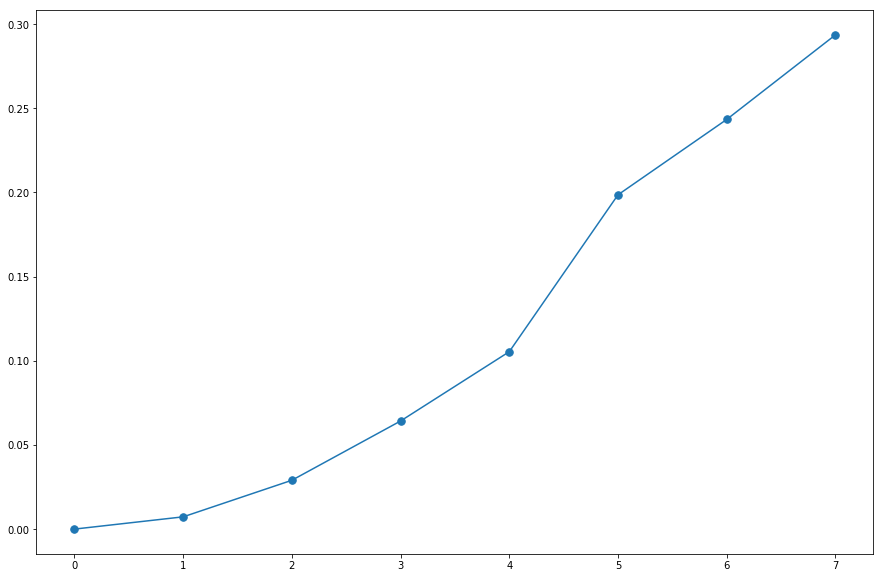

In [41]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(G01.L, k=8, which='SM', return_eigenvectors = True)
plt.plot(eigenvalues, '.-', markersize=15);

The functions *find_neighbors_by_id* and *find_neighbors_by_name* allows us to recommend a defined number of beers (*N*) with respect to a reference beer which is symmbolized by *node*. The variable *node* should represent the node number of the reference beer in the corresponding graph *G*. The function *find_neighbors_by_name* simply "converts" the name into the corresponding node number before calling *find_neighbors_by_id*. The function *find_neighbors_by_id* computes the closest nodes thanks to the weight matrix of the graph *G*.

In [87]:
def find_neighbors_by_id(Graph, node, N): # Graph, node selected, number of neighbors desired
    if (node>Graph.W.shape[0]-1):
        raise ValueError('The node is not in the graph')
    w = Graph.W
    return_indices = [0]*N
    weigths_not_sparse = [0]*w.shape[0]
    for i in range(0, len(weigths_not_sparse)):
        weigths_not_sparse[i] = w[node,:][0,i]
    sorted_indices = np.flip(np.argsort(weigths_not_sparse), axis=0)
    for i in range(0,N):
        return_indices[i] = sorted_indices[i]
    return return_indices

In [88]:
def find_neighbors_by_name(G, name, N):
    b = beers['name'].str.contains(name)
    #print(beers['name'])
    b = b[b==True]
    #print(b)
    if (len(b.index.values)>0):
        name_id = b.index.values[0]
    #if (name_id in list_indices):
        node_id = list_indices.tolist().index(name_id)
        neighbors = find_neighbors_by_id(G, node_id, N)
        return neighbors, node_id
    else :
        raise ValueError('The beer is not in the graph')

In [44]:
# choice of the node
node = list_indices.tolist().index(0)

neighboors1 = find_neighbors_by_id(G1,node,5)
neighboors05 = find_neighbors_by_id(G05,node,5)
neighboors01 = find_neighbors_by_id(G01,node,5)
neighboors10 = find_neighbors_by_id(G10,node,5)
neighboors1.append(node)
neighboors05.append(node)
neighboors01.append(node)
neighboors10.append(node)

[14475  9451 12605 14469 11453   261 13275  8438    88 12525]
[ 9451 12605 14475 14469 11453 13578   261  6627 13901 13275]
[ 9451 12605 13384 14475 13901  6627    95 13578 11453 14469]
[14475 14469   261  8438 11453 13650 14445 13612 13275    88]


Once we found the neighbors, we want to represent our data on a 2D graph. We chose to represent it on a map as in the section [Visualization of the Dataset](#visualization). To do so, we decided to set the coordinates of the graph as the longitude and latitude of the nodes. Moreover, we plot three graphs with each a feature as a signal and we highlight the nodes we found as a recommendation from the reference node. For this part, the weights of the distance matrix of the localisations feature were set to 0.1 in order to have less importance. However, the calculs were made for different weights and the different results are shown below.

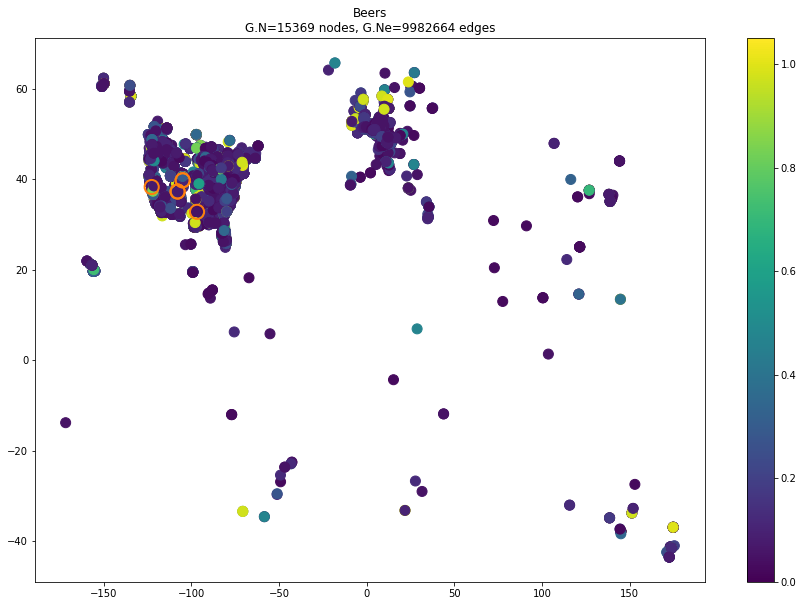

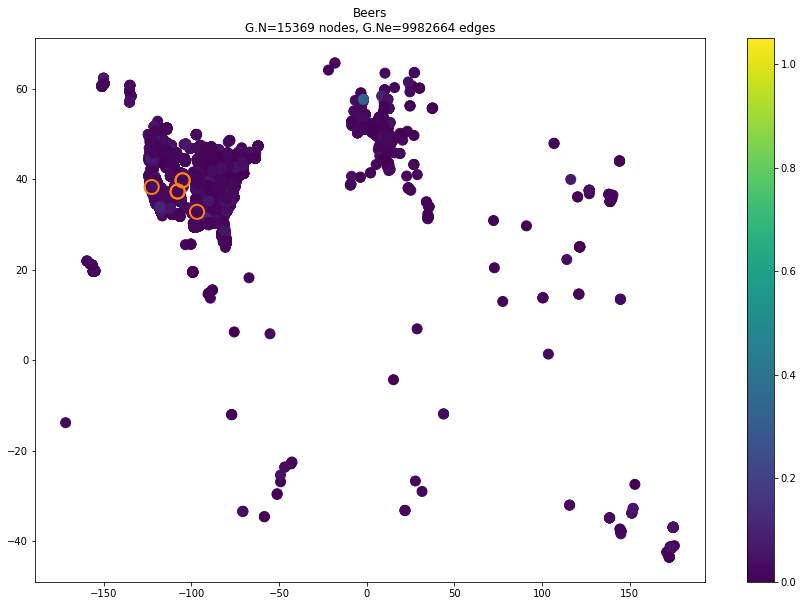

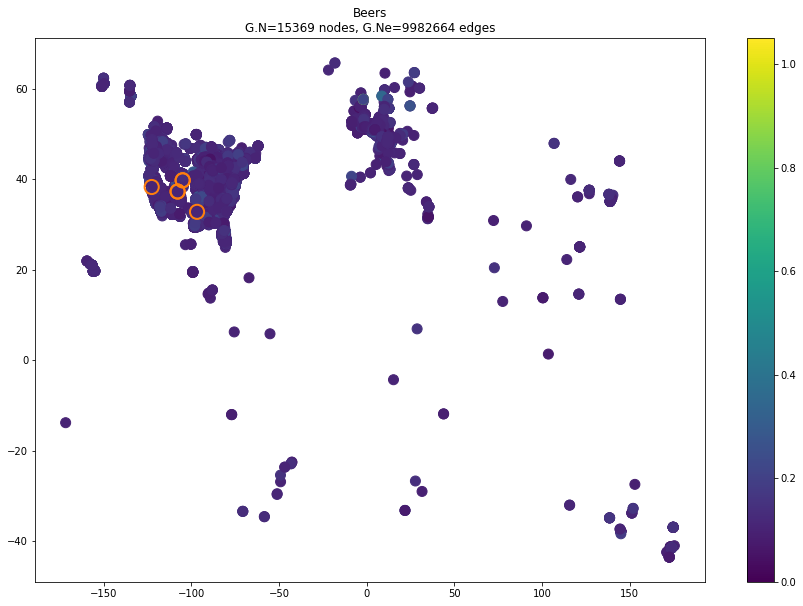

In [45]:
G01.set_coordinates(np.array([beers['longitude'].tolist(), beers['latitude'].tolist()]).transpose())#G.U[:, 1:3])

beers_normalized = pd.DataFrame(index=list_indices, columns=features, data=Feature)
LongLat_normalized = mapColumn(LongLat)
loc_normalized = pd.DataFrame(index=list_indices, columns=['longitude','latitude'], data=LongLat_normalized)
G01.plot_signal(beers_normalized['srmId'], highlight=neighboors01)
G01.plot_signal(beers_normalized['ibu'], highlight=neighboors01)
G01.plot_signal(beers_normalized['abv'], highlight=neighboors01)

The points on the graphs are plotted on the top of each other. For this reason some of the points are unable to be seen.

## Comparison of the distance weights for beer features

We can see that with a distance weight of 0.1, the beers that are selected as close are still in the same area. The different colours show the values of the others features. However, since it is difficult to see the different colours, the values are displayed below and for different distance weights respectively, 1, 10, 0.1, 0.5.

In [46]:
beers_normalized.iloc[neighboors1]

,abv,ibu,srmId
15541,0.250277,0.119119,0.425
10040,0.232558,0.071071,0.400
13449,0.223699,0.099099,0.425
15533,0.281285,0.029029,0.425
12201,0.224585,0.101101,0.375
0,0.241417,0.074074,0.425


For the distance weight of 1, we can see that the three features are pretty close but differ a bit, which can be convenient since the idea of the recommendation is to advice on other possible beer that have similarities without being exactly the same.

In [47]:
beers_normalized.iloc[neighboors10]

,abv,ibu,srmId
15541,0.250277,0.119119,0.425
15533,0.281285,0.029029,0.425
303,0.181617,0.041041,0.400
8988,0.208195,0.019019,0.475
12201,0.224585,0.101101,0.375
0,0.241417,0.074074,0.425


For the distance weight of 10, we can see that these features a less close, indeed there are more different in comparison of the previous weight.

In [48]:
beers_normalized.iloc[neighboors01]

,abv,ibu,srmId
10040,0.232558,0.071071,0.400
13449,0.223699,0.099099,0.425
14310,0.252492,0.083083,0.400
15541,0.250277,0.119119,0.425
14892,0.265781,0.042543,0.425
0,0.241417,0.074074,0.425


The weight distance is the one that we kept. We can see that the beer features are quite close but with different combinations of abv, ibu and srm.

In [49]:
beers_normalized.iloc[neighboors05]

,abv,ibu,srmId
10040,0.232558,0.071071,0.400
13449,0.223699,0.099099,0.425
15541,0.250277,0.119119,0.425
15533,0.281285,0.029029,0.425
12201,0.224585,0.101101,0.375
0,0.241417,0.074074,0.425


This weight distance of 0.5 was chosen for a comparison with the previous one, in order to see if the difference was significant. As a result, we see that the beer features differe more from one to another.

## Comparison of the distance weights for distance features

Then a comparison with the distance feature was also made in order to see what how much accuracy on the localisation was lost.

In [50]:
loc_normalized.iloc[neighboors1]

,longitude,latitude
15541,0.192236,0.762491
10040,0.183918,0.739787
13449,0.183918,0.739810
15533,0.192236,0.762491
12201,0.191581,0.764909
0,0.192219,0.762519


For a weight distance of 1 we can see that the localization are quite close, the localisation has the same impact than the other features. Thus all the beers selected are in the same area.

In [51]:
loc_normalized.iloc[neighboors10]

,longitude,latitude
15541,0.192236,0.762491
15533,0.192236,0.762491
303,0.192168,0.762353
8988,0.192245,0.762504
12201,0.191581,0.764909
0,0.192219,0.762519


Fow a weight distance of 10, the localization has much more impact, thus we can see that the locations of the beers are much more closer to each other. 

In [52]:
loc_normalized.iloc[neighboors01]

,longitude,latitude
10040,0.183918,0.739787
13449,0.183918,0.739810
14310,0.141351,0.748943
15541,0.192236,0.762491
14892,0.215876,0.698664
0,0.192219,0.762519


For a weight distance of 0.1, we can see that we loose accuracy on the localisation but as seen on the figure above, the beers are still located in the USA but not so close to each other.

In [53]:
loc_normalized.iloc[neighboors05]

,longitude,latitude
10040,0.183918,0.739787
13449,0.183918,0.739810
15541,0.192236,0.762491
15533,0.192236,0.762491
12201,0.191581,0.764909
0,0.192219,0.762519


As for the previous weight distance, we can see a loss in the location but smaller.

## Conclusion of Weight distances

From the values collected above, the distance weight of 0.1 was chosen because the location was chosen as less important than the other features. Moreover by comparison of the accuracy loss on location and the accuracy gain on the other features, it seemed as a good tread-off.

** DEMO **

A small example of the way the recommendation could be used by giving a beer name is done below.

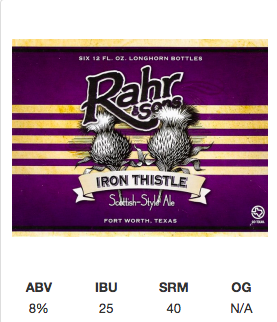

In [91]:
Image("beer.png") 

In [90]:
recommendations, node_id = find_neighbors_by_name(G01, 'Iron Thistle', 5)
beers_normalized.iloc[recommendations]

,abv,ibu,srmId
4063,0.174972,0.026026,0.975
16325,0.179402,0.024024,0.975
15375,0.174972,0.024024,0.975
13423,0.174972,0.018018,0.975
15775,0.179402,0.027027,0.975


Thus for example if we choose the first selection.

In [94]:
beers.loc[4063]['name']

'Cherry Chocolate Double Brown Stout'

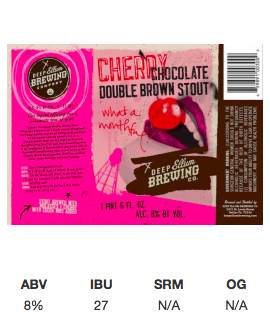

In [95]:
Image("beer2.png") 

<a id='clustering'></a>
## Clustering

In this section, we want to clusterize the beers over their features, in order to see if we can identify some common characteristics for groups of beers. To do so, we firstly did a clustering of the features on the location (longitude and latitude), and then on the intrinsic features (abv, ibu, srm). Even if the clustering on the locations seems obvious, it permits to test the algorithm and to really establish the main locations of breweries. The second one is more relevant, and we tried to determine a global scheme about the beers. 

To clusterize our data, we use the DBSCAN algorithm because it allows us to re-use our distance metric. We thus do not need to recompute distance at every step. As the size of our dataset is about 15'000 points, computing distances represents a too large amount of time. Moreover, DBSCAN can handle the outliers which is not the case of K-means for instance and we thus do not need to take care of them manually.

### Locations clustering

In [54]:
lats_beers = np.array(beers['latitude'].values)
lons_beers = np.array(beers['longitude'].values)

For the first clustering, we use the matrix *D_distances* which contains all the previously computed haversine distances. We first ensure that it is a symmetric matrix, in order to be sure that DBSCAN runs correctly.

In [55]:
# Make D symmetric
bigger = D_distances.transpose() > D_distances
D_distances_sym = D_distances - D_distances*bigger + D_distances.transpose()*bigger

We can now run DBSCAN with parameters ($\epsilon$ and *min_samples*) that we determined empirically, and in order to see the clusterization, we plot the points along the axis of longitude and latitude.

In [56]:
myProj = Proj("+proj=utm +zone=33 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
UTMx, UTMy = myProj(LongLat[:,0], LongLat[:,1])

UTMxy = np.zeros((tot_beers, 2))
UTMxy[:,0] = UTMx
UTMxy[:,1] = UTMy

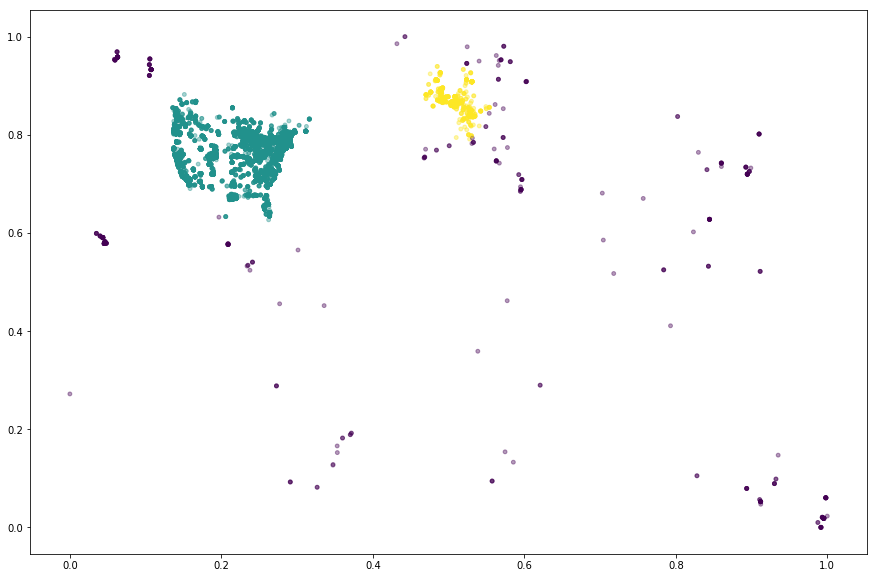

In [57]:
# metric precomputed because we have the distance matrix
estimator = DBSCAN(eps=600, min_samples=500, metric="precomputed") 
estimator.fit_predict(D_distances_sym)

plt.scatter(LongLat[:,0], LongLat[:,1], marker='o',c=estimator.labels_, s=15, zorder=5, alpha=0.4)

In order to have a better visualization, we "merge" this clustering part with the visualization part ([Visualization of the Dataset](#visualization)), as we used a Mercator projection to plot the data in 2D.

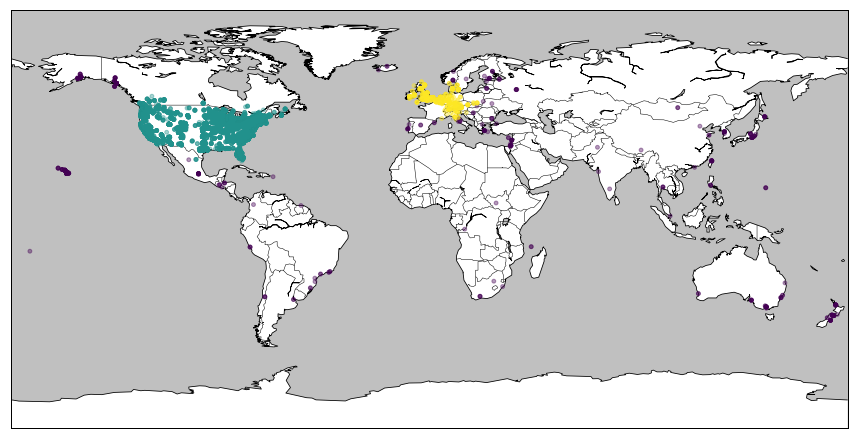

In [62]:
my_map = Basemap(projection='cyl')

my_map.drawmapboundary(fill_color='silver')
my_map.fillcontinents(color='white', lake_color='silver', ax=None, zorder=None, alpha=None)
my_map.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
my_map.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


x_lons, y_lats = my_map(lons_beers, lats_beers)


my_map.scatter(x_lons, y_lats, marker='o',c=estimator.labels_, s=15, zorder=5, alpha=0.4)
plt.show()

We can see on the map that, depending on their own location, the beers that are close are in the same cluster. 

### Features clustering

We want now to clusterize the beers over their intrinsic features. As in the prevous section, we need to ensure that the distance matrix is symmetric.

In [63]:
# Make D_features symmetric
bigger = D_features.transpose() > D_features
D_features_sym = D_features - D_features*bigger + D_features.transpose()*bigger

We also used DBSCAN to ensure the handling of the outliers, and the parameters are also determined empirically.

In [112]:
# metric precomputed because we have the distance matrix
estimator = DBSCAN(eps=0.03, min_samples=70, metric="precomputed") 
estimator.fit_predict(D_features_sym)

array([-1,  0, -1, ...,  1,  1,  1])

This time, we do not want to plot the points with the locations as axis, but on the two first eigenvectors. We know that the projection on the two first eigenvectors should give the best 2D representation of our data in terms of its variance, so we decided to plot it with the eigenvectors as axis. That is why we need to compute the weight matrix corresponding to the features distance only and be able to build the graph. Once we have the graph, we can compute the Laplacian and then, the Fourier basis which gives us the eigenvectors.

In [84]:
# Gaussian kernel
kernel_width_features = D_features.mean()*kernel_width_coef
W_feat = np.exp(-D_features_sym**2/kernel_width_features**2) 
np.fill_diagonal(W_feat,0)

NEIGHBORS = 100

for i in tqdm(range (0, int(W_feat.shape[0]))):
    sorted_indices = np.argsort(W_feat[i,0:(W_feat.shape[0])])

    for j in range (0, len(sorted_indices)-NEIGHBORS):
        W_feat[i,sorted_indices[j]]=0
        
# from assignment 1
bigger = W_feat.transpose() > W_feat
W_feat = W_feat - W_feat*bigger + W_feat.transpose()*bigger
#plt.spy(W_feat)

G_feat = graphs.Graph(W_feat, gtype="Beers")
G_feat.compute_laplacian(lap_type="normalized")
G_feat.compute_fourier_basis(recompute=False)

G_feat.set_coordinates(G_feat.U[:,1:3])

100%|██████████| 15369/15369 [02:19<00:00, 109.91it/s]
2018-01-22 21:13:19,066:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (15369 x 15369) may take some time.


We need to choose wisely the bounds of our axis, because some outliers are so far that we cannot distinguish the distance between the other points on the graph.

(-1e-05, 1e-05)

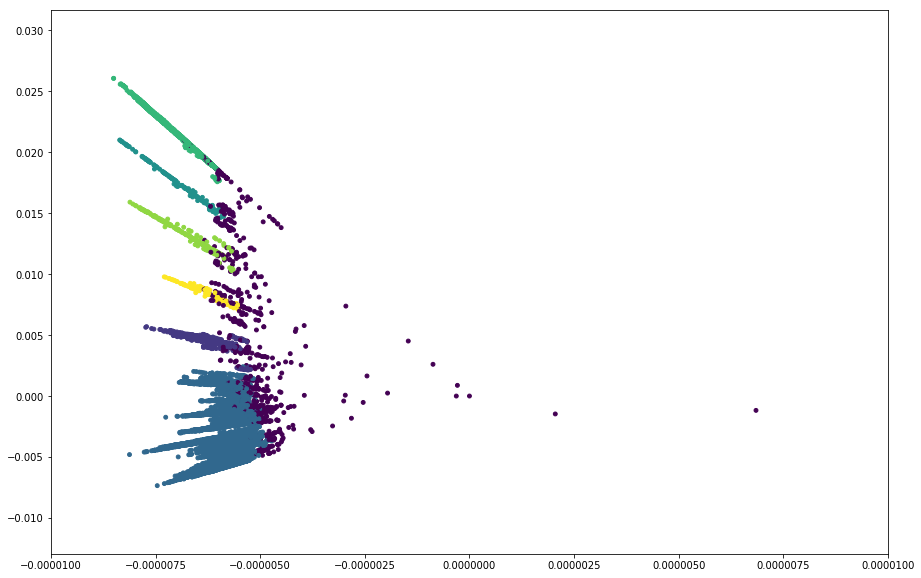

In [113]:
#G_feat.plot()
#plt.scatter(LongLat[:,0], LongLat[:,1], marker='o',c=estimator.labels_, s=15, zorder=5, alpha=0.4)
plt.scatter(G_feat.U[:,1], G_feat.U[:,2], marker='o',c=estimator.labels_, s=15, zorder=5, alpha=1)
plt.xlim(-0.00001,0.00001)

As we can see on the graph, six different clusters are identified by DBSCAN which correspond to six different types of beers with uniform features combination. One of the clusters is bigger than the other probably due to the high amount of mainstream blond beers.

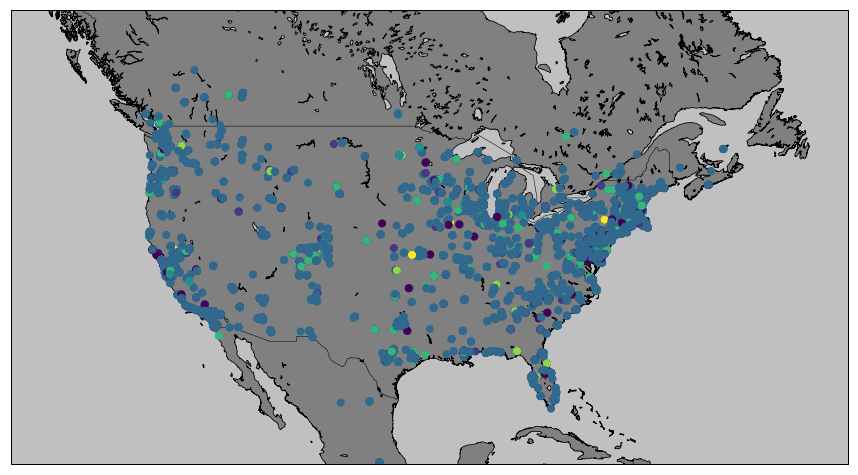

In [120]:
# Plot of America
ll_corner = [-139.174805, 19.344837] #long, lat
ur_corner = [-48.471680, 56.579154] #long, lat 

mymap = Basemap(llcrnrlon=ll_corner[0],
              llcrnrlat=ll_corner[1],
              urcrnrlon=ur_corner[0],
              urcrnrlat=ur_corner[1],
              resolution = 'i',
              projection='merc',
              lon_0 = 0,
              lat_0 = 0)

mymap.drawmapboundary(fill_color='silver')
mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)

x_lons, y_lats = mymap(lons_beers, lats_beers)

mymap.scatter(x_lons, y_lats, marker='o',c=estimator.labels_, s=50, zorder=5, alpha=1)
plt.show()

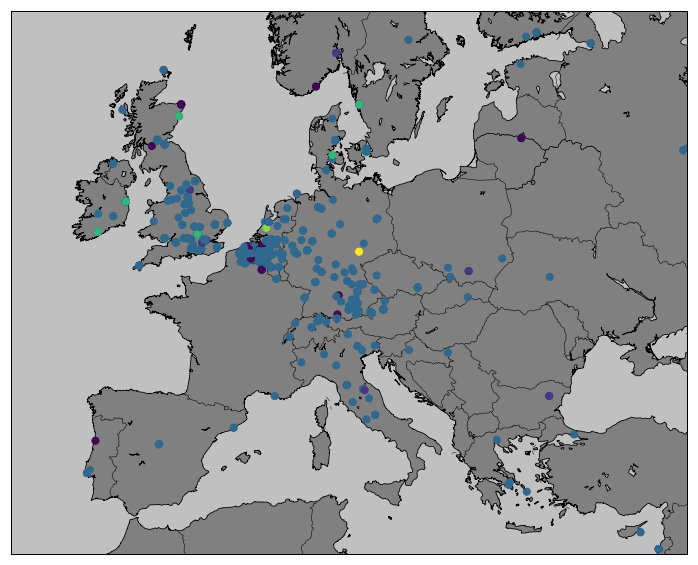

In [121]:
# Plot of Europe
ll_corner = [-15.292969, 33.550551] #long, lat
ur_corner = [37.749023, 61.371726] #long, lat 

mymap = Basemap(llcrnrlon=ll_corner[0],
              llcrnrlat=ll_corner[1],
              urcrnrlon=ur_corner[0],
              urcrnrlat=ur_corner[1],
              resolution = 'i',
              projection='merc',
              lon_0 = 0,
              lat_0 = 0)

mymap.drawmapboundary(fill_color='silver')
mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)

x_lons, y_lats = mymap(lons_beers, lats_beers)

mymap.scatter(x_lons, y_lats, marker='o',c=estimator.labels_, s=50, zorder=5, alpha=1)
plt.show()

The two previous figures are a geographic representation of the clusters. As expected, all clusters are spread on each area of the maps. Since there was a bigger cluster, we can see that it is leading in the maps.

<a id='conclusion'></a>
# Conclusion

This project aimed at giving a general overview about beer suggestion. We started by gathering data from BreweryDB. To do so, we created an app on the website to be able to get the data with an API. As a lot of values were missing in the dataFrame we created from the data, we needed to find other ways to get them. We performed a cleaning by replacing the missing data by deducing them from other features and we had to replace some of them to be able to save and retreive the all dataFrame. Afterwards, the goal was to make the actual suggestion of beers, from a given beer. We took our own distance metric to establish the relationship between all the beers and we built the distances and weigths matrices. From there, we obtained the graph which allowed us to make recommendations. 

In the meantime, we wanted to have a graphical visualization of our data, and since two of them define the location of the brewery corresponding to the beer, we decided to plot the data on a world map. 

Finally, combining all the previous computations, we were able to clusterize our data with respect to the intrinsic features of the beers, and, on the other hand, the location features. We compared the clusters we found with the origin of the beers to see if we could see a correlation. As a preliminary result, we can see that the features of the beers have no correlation with the locations. Some improvement on the tuning of the parameters for the clustering can be done. Having some new features from the database could also change the clustering results.